### STEP 1 - Data Acquisition 

In order to collect wikipedia traffic data from 2008-2021, we collect data from two different publicly available API endpoints. The legacy pagecount API and the pageviews API.

We collect desktop and mobile traffic data from Dec 2007 - July 2016 from the legacy pagecounts API.

We collect desktop, mobile web and mobile app traffic data from July 2015 - August 2021 from the pageviews API. 

We store the results in 5 separate json data files. We specifically filter out results from web crawlers and spiders by setting agent to user. 

In [1]:
import json
import requests

In [2]:
# desktop and mobile traffic data (dec2007-July2016)
endpoint_pagecounts = 'https://wikimedia.org/api/rest_v1/metrics/legacy/pagecounts/aggregate/{project}/{access-site}/{granularity}/{start}/{end}'

# desktop, mobile web and mobile app traffic (July2015 - last month)
endpoint_pageviews = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/{project}/{access}/{agent}/{granularity}/{start}/{end}'

In [3]:
pagecounts_desktop_all = {"project" : "en.wikipedia.org",
                     "access-site" : "desktop-site",
                     "granularity" : "monthly",
                     "start" : "2008010100",
                     "end" : "2016080100"
                    }

    
pagecounts_mobile_all = {"project" : "en.wikipedia.org",
                     "access-site" : "mobile-site",
                     "granularity" : "monthly",
                     "start" : "2008010100",
                     "end" : "2016080100"
                    }


pageviews_desktop_all = {"project" : "en.wikipedia.org",
                      "access" : "desktop",
                      "agent" : "user",
                      "granularity" : "monthly",
                      "start" : "2015070100",
                       "end" : '2021090100'
                    }

pageviews_mobile_web_all = {"project" : "en.wikipedia.org",
                      "access" : "mobile-web",
                      "agent" : "user",
                      "granularity" : "monthly",
                      "start" : "2015070100",
                       "end" : '2021090100'
                     }

pageviews_mobile_app_all = {"project" : "en.wikipedia.org",
                       "access" : "mobile-app",
                       "agent" : "user",
                       "granularity" : "monthly",
                       "start" : "2015070100",
                       "end" : '2021090100'
                    }

### Custom user headers

In [4]:
headers = {
    'User-Agent': 'https://github.com/poornima-muthukumar',
    'From': 'muthupoo@uw.edu'
}

In [5]:
def api_call(endpoint, parameters):
    call = requests.get(endpoint.format(**parameters), headers=headers)
    response = call.json()
    
    return response

In [6]:
pagecounts_desktop = api_call(endpoint_pagecounts, pagecounts_desktop_all)
pagecounts_mobile = api_call(endpoint_pagecounts, pagecounts_mobile_all)
pageviews_desktop = api_call(endpoint_pageviews, pageviews_desktop_all)
pageviews_mobile_web = api_call(endpoint_pageviews, pageviews_mobile_web_all)
pageviews_mobile_app = api_call(endpoint_pageviews, pageviews_mobile_app_all)

In [7]:
with open('pagecounts_desktop-site_200801-201607.json', 'w') as file:
    json.dump(pagecounts_desktop, file)
with open('pagecounts_mobile-site_200801-201607.json', 'w') as file:
    json.dump(pagecounts_mobile, file)
with open('pageviews_desktop-site_201507-202108.json', 'w') as file:
    json.dump(pageviews_desktop, file)
with open('pageviews_mobile-web-site_201507-202108.json', 'w') as file:
    json.dump(pageviews_mobile_web, file)
with open('pageviews_mobile-app-site_201507-202108.json', 'w') as file:
    json.dump(pageviews_mobile_app, file)

### STEP 2 - Data Processing

We will perform some data processing on these data files to prepare them for analysis.  

1. Combine monthly values for mobile app and mobile web from pageview api.
2. Separate the value of timestamp into (YYYY) and (MM) and discard (DDHH)
3. If no traffic is available for a given access method, mark it as 0. 
4. Combile all data in one file for analysis. 

In [8]:
import pandas as pd

### Convert to data frame to manipualte data.

In [9]:
pagecount_desktop_df = pd.DataFrame.from_dict(pagecounts_desktop['items'])
pagecounts_mobile_df = pd.DataFrame.from_dict(pagecounts_mobile['items'])
pageviews_desktop_df = pd.DataFrame.from_dict(pageviews_desktop['items'])
pageviews_mobile_web_df = pd.DataFrame.from_dict(pageviews_mobile_web['items'])
pageviews_mobile_app_df = pd.DataFrame.from_dict(pageviews_mobile_app['items'])

In [10]:
pagecount_desktop_df.rename(columns={'count': 'pagecount_desktop_views'}, inplace='True')
pagecounts_mobile_df.rename(columns={'count': 'pagecount_mobile_views'}, inplace='True')
pageviews_desktop_df.rename(columns={'views': 'pageviews_desktop_views'}, inplace='True')
pageviews_mobile_web_df.rename(columns={'views': 'pageviews_mobile_web_views'}, inplace='True')
pageviews_mobile_app_df.rename(columns={'views': 'pageviews_mobile_app_views'}, inplace='True')

### 3. If no traffic is available for a given access method, mark it as 0. 

In [11]:
data = pagecount_desktop_df[['timestamp', 'pagecount_desktop_views']]
data = data.merge(pagecounts_mobile_df[['timestamp', 'pagecount_mobile_views']], how = 'outer', on='timestamp')
data = data.merge(pageviews_desktop_df[['timestamp', 'pageviews_desktop_views']], how = 'outer', on='timestamp')
data = data.merge(pageviews_mobile_web_df[['timestamp', 'pageviews_mobile_web_views']], how = 'outer', on='timestamp')
data = data.merge(pageviews_mobile_app_df[['timestamp', 'pageviews_mobile_app_views']], how = 'outer', on='timestamp')

In [12]:
data['pagecount_desktop_views'].fillna(0, inplace=True)
data['pagecount_mobile_views'].fillna(0,  inplace=True)
data['pageviews_desktop_views'].fillna(0,  inplace=True)
data['pageviews_mobile_web_views'].fillna(0,  inplace=True)
data['pageviews_mobile_app_views'].fillna(0,  inplace=True)

### 2. Separate the value of timestamp into (YYYY) and (MM) and discard (DDHH)

In [13]:
data_merged = pd.DataFrame({'year':data['timestamp'].str[0:4],  
                                  'month':data['timestamp'].str[4:6],                                   
                                  'pagecount_all_views':data['pagecount_desktop_views']+data['pagecount_mobile_views'],
                                  'pagecount_desktop_views':data['pagecount_desktop_views'], 
                                  'pagecount_mobile_views':data['pagecount_mobile_views'],
                                  'pageview_all_views':data['pageviews_desktop_views']+data['pageviews_mobile_app_views']+data['pageviews_mobile_web_views'],
                                  'pageview_desktop_views':data['pageviews_desktop_views'],
                                  'pageview_mobile_views':data['pageviews_mobile_app_views']+data['pageviews_mobile_web_views']})

In [14]:
data_merged.astype({'pagecount_all_views': 'int',
                   'pagecount_desktop_views': 'int',
                   'pagecount_mobile_views': 'int',
                   'pageview_all_views': 'int',
                   'pageview_desktop_views': 'int',
                   'pageview_mobile_views': 'int'})

,year,month,pagecount_all_views,pagecount_desktop_views,pagecount_mobile_views,pageview_all_views,pageview_desktop_views,pageview_mobile_views
0,2008,01,4930902570,4930902570,0,0,0,0
1,2008,02,4818393763,4818393763,0,0,0,0
2,2008,03,4955405809,4955405809,0,0,0,0
3,2008,04,5159162183,5159162183,0,0,0,0
4,2008,05,5584691092,5584691092,0,0,0,0
...,...,...,...,...,...,...,...,...
159,2021,04,0,0,0,7641809575,2882714492,4759095083
160,2021,05,0,0,0,7800995735,2824416177,4976579558
161,2021,06,0,0,0,7090481783,2505971366,4584510417
162,2021,07,0,0,0,7544493789,2765584368,4778909421


### 4. Combile all data in one file for analysis. 

In [15]:
data_merged.to_csv("en-wikipedia_traffic_200712-202108.csv", index=False)

# Step - 3 - Analysis¶

Here we will plot the time series graph of the site traffic data, showing mobile, desktop and all (Mobile + Desktop) combined data.

To visualize the data, the matplotlib python library is used. 

In [16]:
import matplotlib.pyplot as plt  
from matplotlib.pyplot import figure

In [17]:
data_merged['date'] = data_merged['year'].astype(str) + data_merged['month'].astype(str)
dates = pd.to_datetime(data_merged['date'],format='%Y%m')

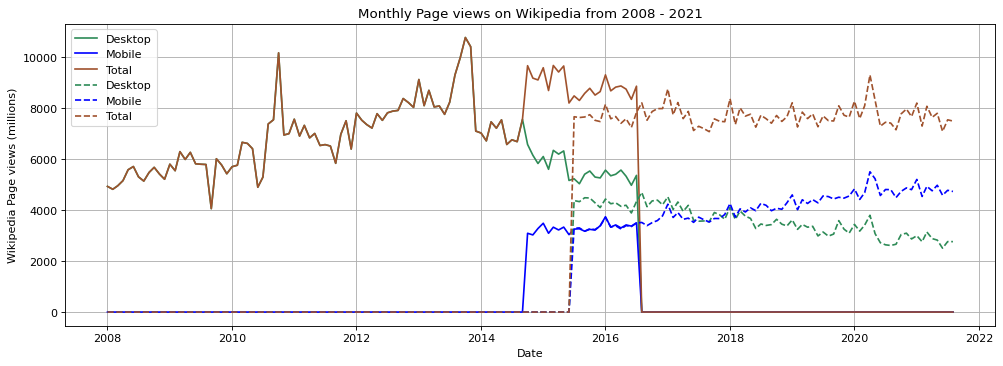

In [18]:
figure(figsize=(15, 5), dpi=80)

plt.grid(True)
plt.plot(dates, data_merged['pagecount_desktop_views']/1e6, color='seagreen', label='Desktop')
plt.plot(dates, data_merged['pagecount_mobile_views']/1e6, color='blue', label='Mobile')
plt.plot(dates, data_merged['pagecount_all_views']/1e6, color='sienna', label='Total')

plt.plot(dates, data_merged['pageview_desktop_views']/1e6, color='seagreen', linestyle="--", label='Desktop')
plt.plot(dates, data_merged['pageview_mobile_views']/1e6, color='blue', linestyle="--", label='Mobile')
plt.plot(dates, data_merged['pageview_all_views']/1e6, color='sienna', linestyle="--", label='Total')

plt.xlabel('Date')
plt.ylabel('Wikipedia Page views (millions)')
plt.title('Monthly Page views on Wikipedia from 2008 - 2021')

plt.savefig('wikipedia_page_views_vizualtization.png')
plt.legend(loc=2)

###  We can see a linear increase in the number of views from 2008 until 2021. With the advent of mobile site (blue dotted line) we can see a decrease in the pageviews of the desktop site (green dotted line).